# Predicted Gripping Point Visualization


1. In this notebook we will walk step by step through the process of using a pre-trained model to detect objects in an image. 
2. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt #from matplotlib import pyplot as plt

from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')


/home/jenny/gripper2/.envpy35/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports & Variables Definition

In [3]:
from utils import label_map_util
from utils import visualization_utils as vis_util

/home/jenny/gripper2/.envpy35/lib/python3.5/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [4]:
tf.logging.set_verbosity(tf.logging.INFO)

#PATH_TO_MAIN_DIR = '/home/jenny/dl/gripper/'
PATH_TO_MAIN_DIR = '/home/jenny/gripper2/'


# DATA:
PATH_TO_DATA_DIR = os.path.join(PATH_TO_MAIN_DIR, 'data/gripper_data/')

# MODEL:
MODEL_NAME = 'faster_rcnn_resnet101_coco_2018_01_28'
PATH_TO_MODEL = os.path.join(PATH_TO_MAIN_DIR, 'tensorflow/detection_models/', MODEL_NAME)

# Path to frozen detection graph. This is the actual model that is used for the object detection.
# Any model exported using the `export_inference_graph.py` tool can be loaded here
# simply by changing `PATH_TO_CKPT` to point to a new .pb file.
PATH_TO_CKPT = os.path.join(PATH_TO_MODEL, 'exported_model/frozen_inference_graph.pb')

# List of the strings that is used to add correct label for each box.
PATH_TO_COCO_LABELS = 
  os.path.join(PATH_TO_MAIN_DIR, 
               'tensorflow/models/research/object_detection/data',
               'mscoco_label_map.pbtxt')
  
NUM_COCO_CLASSES = 90

PATH_TO_GRIPPER_LABELS = os.path.join(PATH_TO_DATA_DIR, 'gripper_label_map.pbtxt')
NUM_GRIPPER_CLASSES = 1  

PATH_TO_LABELS = PATH_TO_COCO_LABELS # TODO fix
NUM_CLASSES = NUM_COCO_CLASSES # TODO fix

# Size, in inches, of the output images.
OUTPUT_IMAGE_SIZE = (12, 8)
OUTPUT_IMAGE_PATH = os.path.join(PATH_TO_DATA_DIR, 'output')

# Model preparation 

## Load a (frozen) Tensorflow model into memory.

In [5]:
def get_detection_graph():
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return detection_graph

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [6]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Read Data from TFRecord

In [7]:
def _parse_function(example_proto):
    features = {
        'image/filename': tf.FixedLenFeature([], tf.string),
        'image/encoded': tf.FixedLenFeature((), tf.string, default_value=''),
        'image/object/bbox/xmin': tf.VarLenFeature(dtype=tf.float32),
        'image/object/bbox/ymin': tf.VarLenFeature(dtype=tf.float32),
        'image/object/bbox/xmax': tf.VarLenFeature(dtype=tf.float32),
        'image/object/bbox/ymax': tf.VarLenFeature(dtype=tf.float32)}
    example = tf.parse_single_example(example_proto, features)

    image_filename = example['image/filename']
    image = tf.image.decode_png(example['image/encoded'])

    xmin = tf.expand_dims(example['image/object/bbox/xmin'].values, 0)
    ymin = tf.expand_dims(example['image/object/bbox/ymin'].values, 0)
    xmax = tf.expand_dims(example['image/object/bbox/xmax'].values, 0)
    ymax = tf.expand_dims(example['image/object/bbox/ymax'].values, 0)
    bboxes = tf.concat(axis=0, values=[ymin, xmin, ymax, xmax])

    bboxes = tf.expand_dims(tf.transpose(bboxes, [1, 0]), 0)

    return image_filename, image, bboxes

# Detection

In [8]:
def get_tensor_dict(graph):
    with graph.as_default():
        # Get handles to input and output tensors
        ops = tf.get_default_graph().get_operations()
        all_tensor_names = {output.name for op in ops for output in op.outputs}
        tensor_dict = {}
        for key in ['num_detections', 'detection_boxes', 'detection_scores', 'detection_classes']:
            tensor_name = key + ':0'
            if tensor_name in all_tensor_names:
                tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)

        image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')
    return tensor_dict, image_tensor

INFO:tensorflow:Creates a dataset that reads all of the examples from files ------------>
INFO:tensorflow:Starting to iterate the data ------------>
INFO:tensorflow:b'pcd0941r' was extraced.
INFO:tensorflow:bboxes: /n[[[0.6875     0.3640625  0.8272542  0.4625    ]
  [0.675      0.3578125  0.8366125  0.45625   ]
  [0.68541664 0.3328125  0.8111896  0.390625  ]]]
INFO:tensorflow:Writing image WITH BOXES to disk: /home/jenny/gripper2/data/gripper_data/output/pcd0941r
INFO:tensorflow:----------------------
INFO:tensorflow:b'pcd0915r' was extraced.
INFO:tensorflow:bboxes: /n[[[0.57916665 0.353125   0.6716479  0.471875  ]
  [0.62083334 0.353125   0.6906854  0.478125  ]
  [0.5833333  0.353125   0.70411456 0.4765625 ]
  [0.51666665 0.375      0.60751665 0.4421875 ]
  [0.5104167  0.371875   0.61794585 0.4265625 ]
  [0.52916664 0.3765625  0.5825313  0.4421875 ]
  [0.51458335 0.365625   0.6085208  0.45      ]]]
INFO:tensorflow:Writing image WITH BOXES to disk: /home/jenny/gripper2/data/gripper_dat

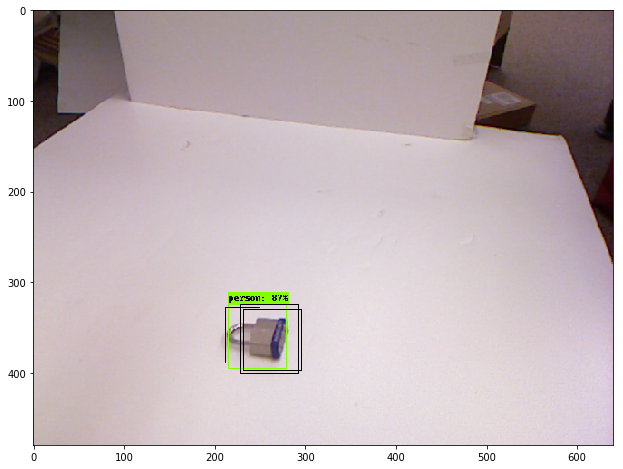

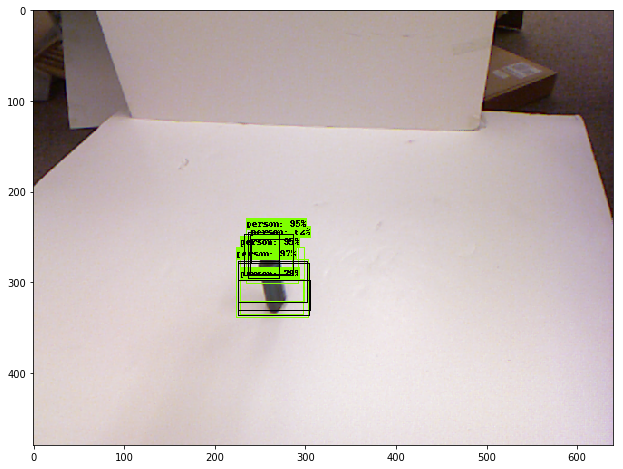

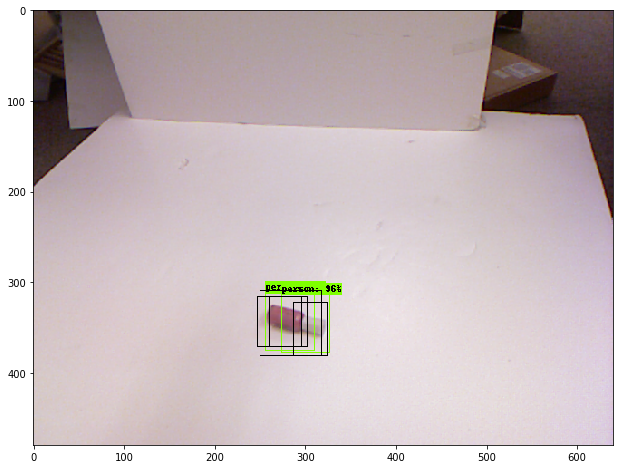

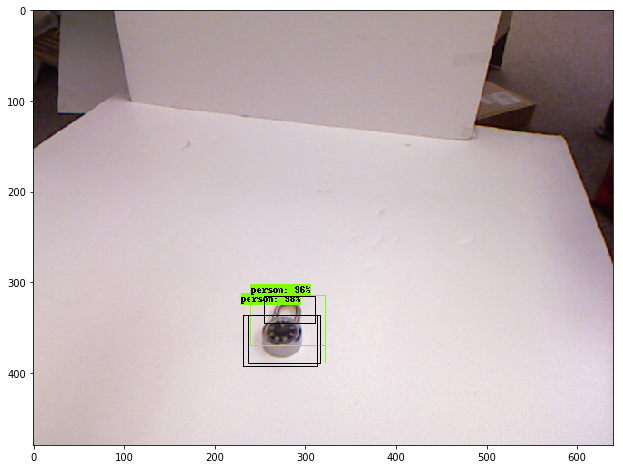

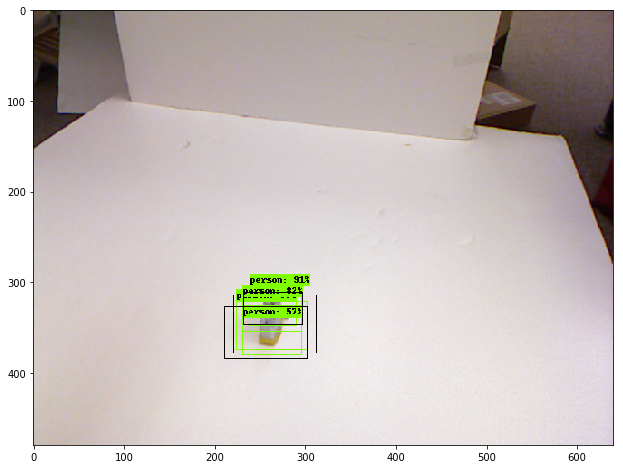

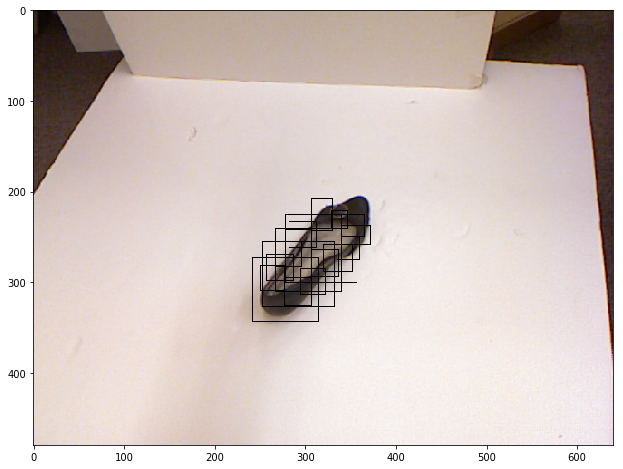

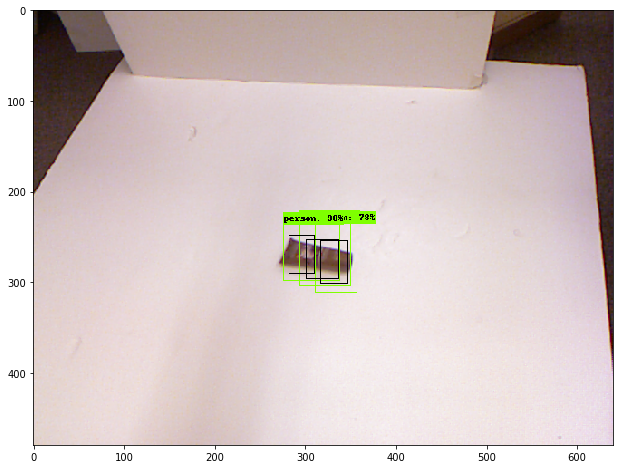

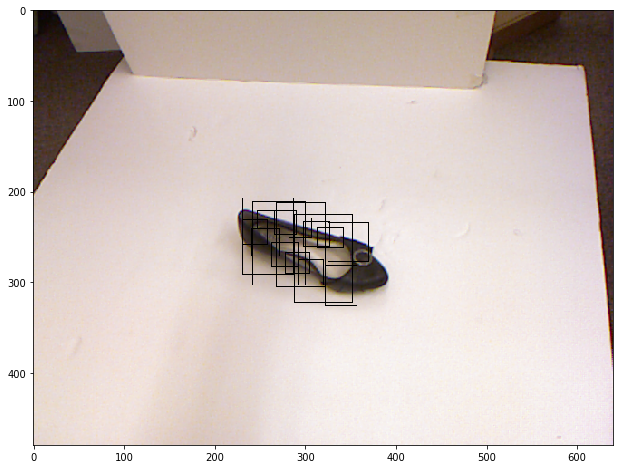

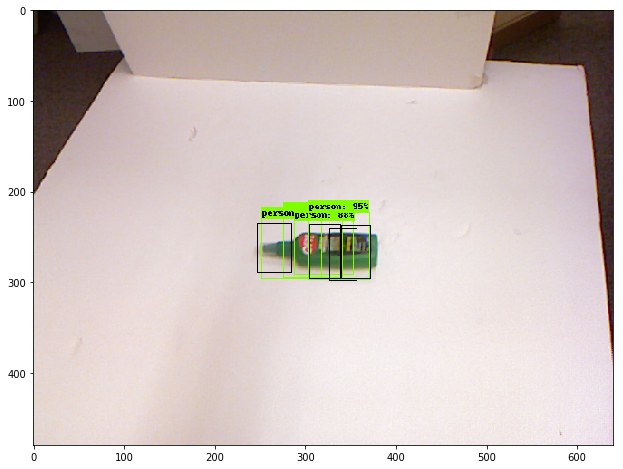

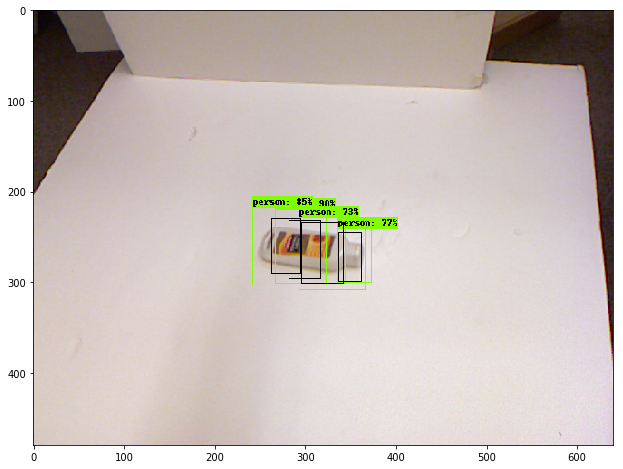

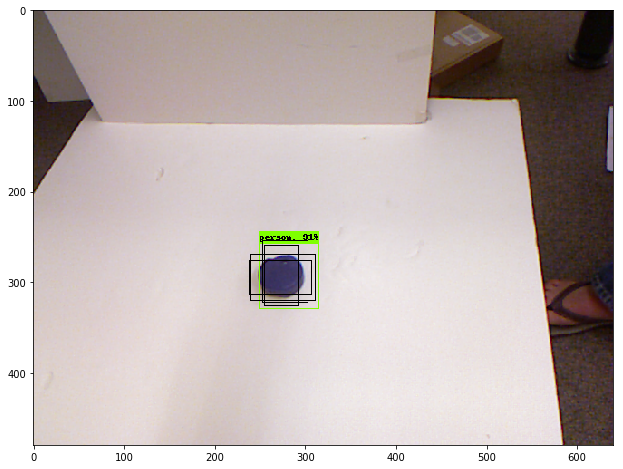

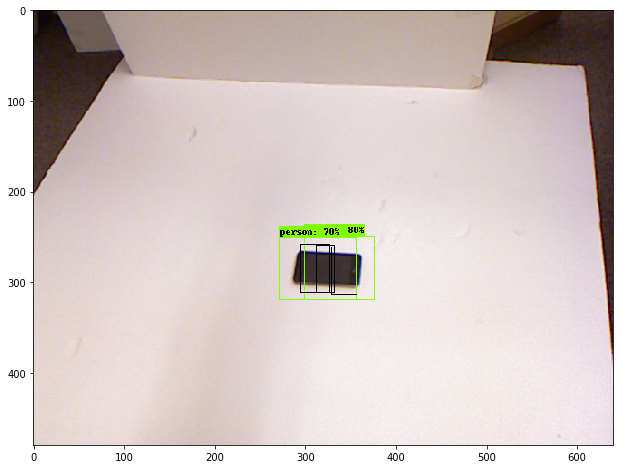

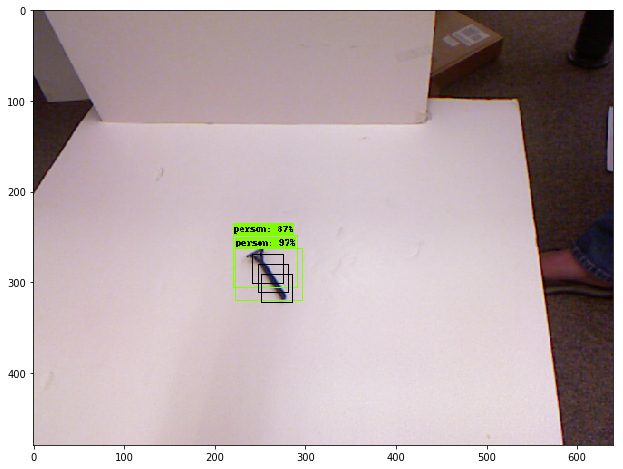

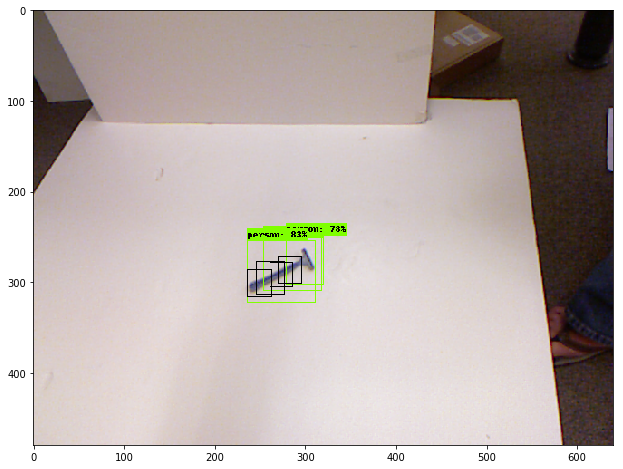

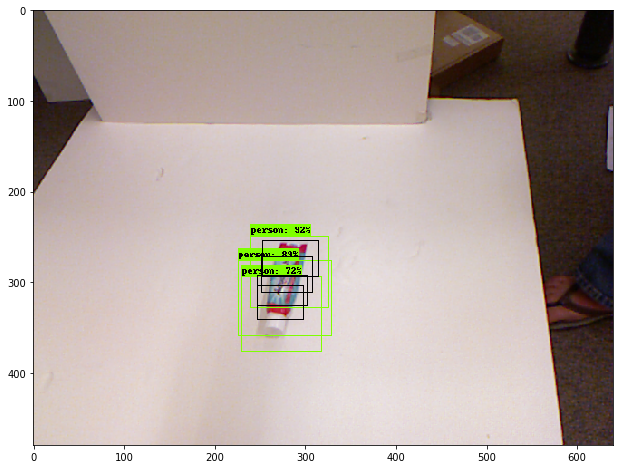

In [10]:
detection_graph = get_detection_graph()
tensor_dict, image_tensor = get_tensor_dict(detection_graph)

with detection_graph.as_default():
    tf.logging.info('Creates a dataset that reads all of the examples from files ------------>')
    filenames = [os.path.join(PATH_TO_DATA_DIR, 'val.record')]
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(_parse_function)  # Parse the record into tensors.
    # dataset = dataset.repeat()  # Repeat the input indefinitely.
    # dataset = dataset.batch(32)
    iterator = dataset.make_one_shot_iterator()  # make_initializable_iterator()

    with tf.Session() as sess:
        sess.run([tf.global_variables_initializer(), tf.local_variables_initializer()])
        threads_coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=threads_coord, sess=sess)
        tf.logging.info('Starting to iterate the data ------------>')
        for i in range(15):
        #while not threads_coord.should_stop():
            try:
                image_filename_v, image_v, bboxes_v = sess.run(iterator.get_next())
                # Run inference
                output_dict_v = sess.run([tensor_dict], feed_dict={image_tensor: np.expand_dims(image_v, 0)})[0]

                # all outputs are float32 numpy arrays, so convert types as appropriate
                output_dict_v['num_detections'] = int(output_dict_v['num_detections'][0])
                output_dict_v['detection_classes'] = output_dict_v['detection_classes'][0].astype(np.uint8)
                output_dict_v['detection_boxes'] = output_dict_v['detection_boxes'][0]
                output_dict_v['detection_scores'] = output_dict_v['detection_scores'][0]

                tf.logging.info('%s was extraced.', image_filename_v)
                tf.logging.info('bboxes: /n%s', bboxes_v)

                # Visualization of the results of a detection.
                vis_util.visualize_boxes_and_labels_on_image_array(
                    image = image_v,
                    boxes = output_dict_v['detection_boxes'],
                    classes = output_dict_v['detection_classes'],
                    scores = output_dict_v['detection_scores'],
                    category_index = category_index,
                    use_normalized_coordinates = True,
                    line_thickness = 1)
                plt.figure(figsize = OUTPUT_IMAGE_SIZE)

                vis_util.visualize_boxes_and_labels_on_image_array(
                    image = image_v,
                    boxes = bboxes_v[0],
                    classes = ['gripper'] * len(bboxes_v[0]),
                    scores = None,
                    category_index = {1: {'id': 1, 'name': 'gripper'}},
                    use_normalized_coordinates = True,
                    line_thickness = 1)
                plt.figure(figsize = OUTPUT_IMAGE_SIZE)

                img_output_path = os.path.join(OUTPUT_IMAGE_PATH, image_filename_v.decode("utf-8"))
                tf.logging.info('Writing image WITH BOXES to disk: %s', img_output_path)
                plt.imsave(img_output_path, image_v)
                plt.imshow(image_v)

                tf.logging.info('----------------------')

            except tf.errors.OutOfRangeError as error:
                threads_coord.request_stop(error)

        threads_coord.request_stop()
        threads_coord.join(threads)